# Time Series Study.

In this notebook we will be more specific on the characteristic of the time series data that have been outlined in Introduction_np1.ipynb.

In particular we will be looking at

- The NIV time series
- The Imbalance price time series
- The VWAP time series

The time series related to the order book will be treated in the very next notebook, since they require some particular care and analysis.

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from Analytics.TimeSeriesTools import * 
import scipy.stats as ss
from ouparams import ouparams

import seaborn as sns



plt.style.use('seaborn')


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

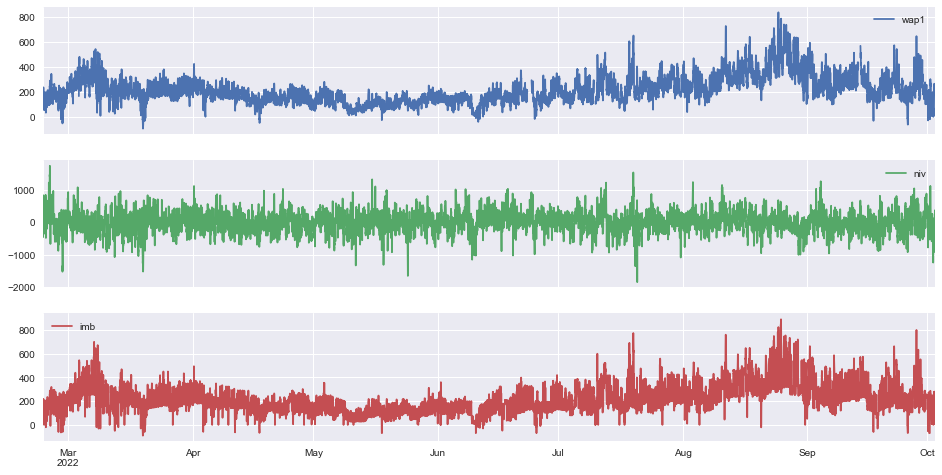

In [2]:
# loading the dataset
df_wap_bal = pd.read_csv('strategy_data_lobniv.csv', index_col = 0, parse_dates=True)
df_wap_bal = df_wap_bal[['wap1', 'niv', 'imb']]

df_wap_bal.plot(figsize = (16,8), subplots=True)

## The NIV Time Series

We will address some peculiarities of the time series, such as

- (weak) stationarity.
- Moments and inference of the distribution.
- stochastic process type determination.

In [18]:
subsets_niv = list(subsetting(df_wap_bal.niv, k=500))

<AxesSubplot:title={'center':'NIV Random Sample'}>

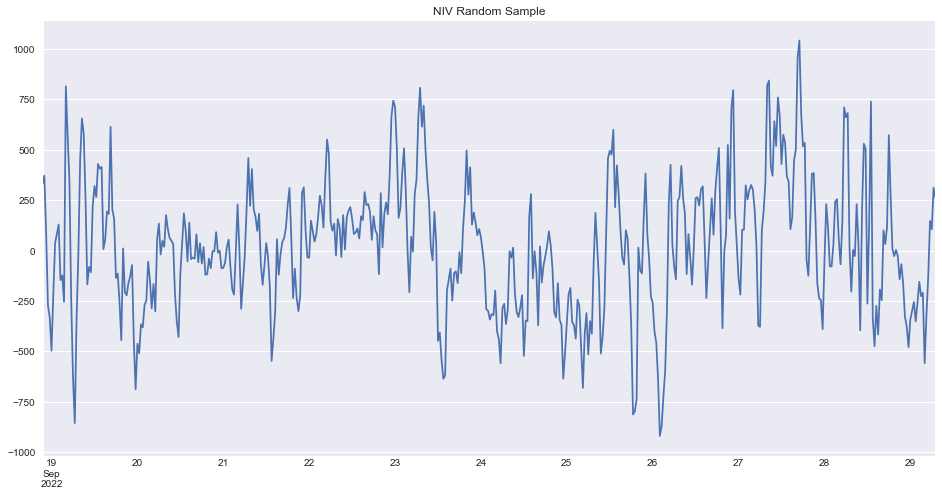

In [21]:
rnd_idx = np.random.choice(len(subsets_niv))
np.random.seed(42)
# Plotting a random sample from the NIV Time Series
subsets_niv[rnd_idx].plot(figsize = (16,8), title = 'NIV Random Sample')

In [39]:
weak_stationarity = {'ADF Test Stationarity': [], 'KPSS Test Stationarity': [], 'Sample': []}
hurst_characteristics = {'Series Type': [], 'Sample': []}


for k in range(len(subsets_niv)):
    
    # ADF and KPSS Tests
    weak_stationarity['ADF Test Stationarity'].append(adf_test_result(subsets_niv[k]))
    weak_stationarity['KPSS Test Stationarity'].append(kpss_test_result(subsets_niv[k]))
    weak_stationarity['Sample'].append(k)
    
    # Hurst Exponent "test"
    hurst_characteristics['Series Type'].append(hurst_test_result(subsets_niv[k]))
    hurst_characteristics['Sample'].append(k)
    
    
result = pd.DataFrame(data = weak_stationarity)
result.set_index('Sample', drop = True, inplace = True)

result_type = pd.DataFrame(hurst_characteristics)
result_type.set_index('Sample', drop=True, inplace=True)


overall_result = pd.concat([result, result_type], axis = 1)

overall_result
                                                       

,ADF Test Stationarity,KPSS Test Stationarity,Series Type
Sample,,,
0,True,True,mr
1,True,True,mr
2,True,False,mr
3,True,True,mr
4,True,True,mr
5,True,True,mr
6,True,True,mr
7,True,True,mr
8,True,True,mr


The unit root test for weak stationarity shows that the time series is weakly stationary for all the samples, whereas in the kpss test, that is a test for trend stationarity, tells that there are some sample that do not show trend stationarity. We can count 3 out of 22 sample where this is shown. This tells that, for this particular split 13% of the cases might have some trends. Nevertheless, the characteristics of the time series, extrapolated with the Hurst exponent shows that the time series is mean reverting. Therefore for overall the samples we would expect a strong coming back to the average value. This is physically and economically motivated since it is the task of the UK power grid to keep the NIV as closest to zero as possible, resulting a well balanced power system.

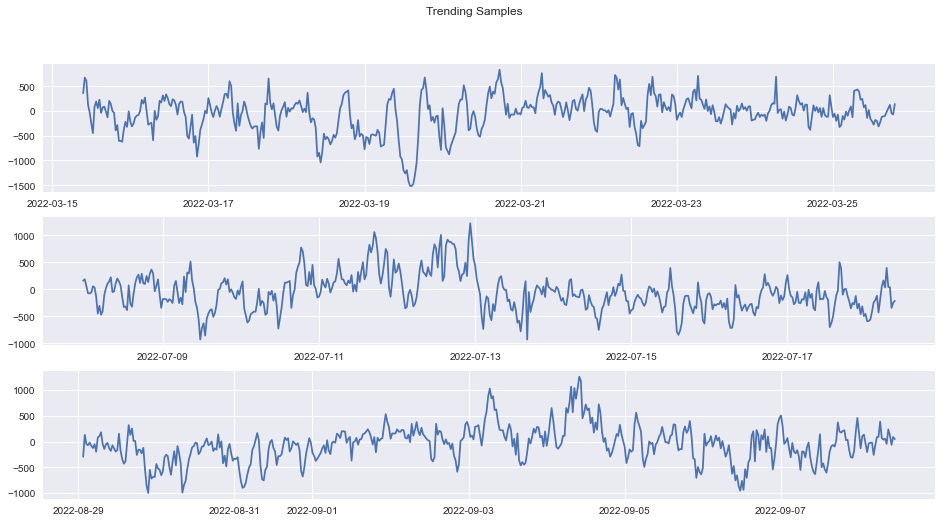

In [33]:
ns1 = subsets_niv[2] 
ns2 = subsets_niv[13] 
ns3 = subsets_niv[18]

fig, axs = plt.subplots(3, figsize = (16,8))
fig.suptitle('Trending Samples')
axs[0].plot(ns1)
axs[1].plot(ns2)
axs[2].plot(ns3)
plt.show()



In [42]:
sample_moments = {'mean': [],
                  'stdev': [],
                  'skewness': [],
                  'kurtosis': [],
                  'excess of kurtosis': [],
                  'Sample': []}

for k in range(len(subsets_niv)):
    
    mean, stdev, skew, kurt, exc_kurt = moments(subsets_niv[k])
    
    sample_moments['mean'].append(mean)
    sample_moments['stdev'].append(stdev)
    sample_moments['skewness'].append(skew)
    sample_moments['kurtosis'].append(kurt)
    sample_moments['excess of kurtosis'].append(exc_kurt)
    sample_moments['Sample'].append(k)
    

sample_moments = pd.DataFrame(sample_moments)
sample_moments.set_index('Sample', drop=True, inplace=True)

sample_moments

,mean,stdev,skewness,kurtosis,excess of kurtosis
Sample,,,,,
0,55.873980,380.525276,-0.087134,3.414375,0.414375
1,-89.185060,344.122667,0.171422,0.057638,-2.942362
2,-57.701360,361.087548,-0.910357,2.013201,-0.986799
3,39.018000,274.394876,0.019696,-0.172528,-3.172528
4,-10.974360,281.876711,0.134108,0.071975,-2.928025
5,21.290840,286.016031,0.310782,0.523621,-2.476379
6,-54.650760,250.714492,-0.449757,0.458229,-2.541771
7,17.356680,316.594276,-0.112492,1.135791,-1.864209
8,-7.224840,333.906243,-0.793850,2.676291,-0.323709


There is a tendency in the samples to behave similarly in terms of skewness and kurtosis. Indeed, all the sample distributions are quite centered and hence "symmetrical", the Kurtosis of the distribution is most likely to be less than 3 (Gaussian Kurtosis), showing that the data are more likely to follow a *platykurtic* distribution, meaning that the data do not present so many extreme events, but are rather centered towards one or two standard deviations away. 

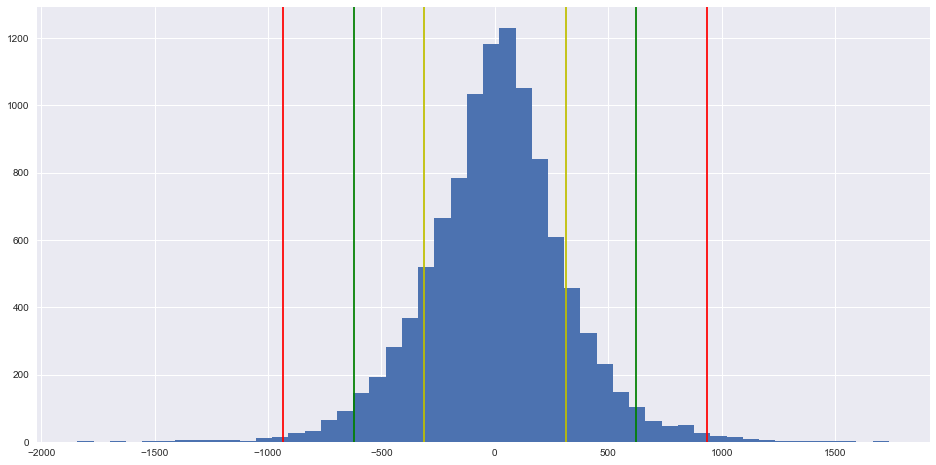

In [44]:
plt.figure(figsize = (16,8))
plt.hist(df_wap_bal.niv, bins=50)
plt.axvline(df_wap_bal.niv.std(), color = 'y')
plt.axvline(-df_wap_bal.niv.std(), color = 'y')
plt.axvline(2 * df_wap_bal.niv.std(), color = 'g')
plt.axvline(-2*df_wap_bal.niv.std(), color = 'g')
plt.axvline(3*df_wap_bal.niv.std(), color = 'r')
plt.axvline(-3*df_wap_bal.niv.std(), color = 'r')
plt.show()

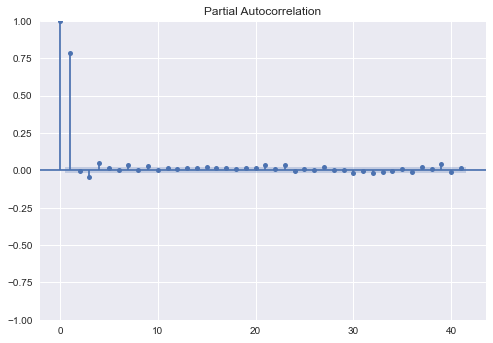

In [45]:
# A quick look at partial autocorrelation

pacf = sm.tsa.graphics.plot_pacf(df_wap_bal.niv)

The partial autocorrelation plot shows autoregression in the process, moreover it tells that every fourth lag there is some mean reversion coming on.

In [156]:
def simulate_ou_process(mu: float, 
                        sigma: float, 
                        theta: float,
                        X0: float,
                        t: np.array) -> np.array:
    
    dt = t[1] - t[0]
    
    X = np.zeros(t.shape)
    X[0] = X0
    
    for i in range(t.size -1):
        
        X[i+1] = X[i] + mu * (theta - X[i])*dt + sigma*np.sqrt(dt)*np.random.normal()
        
    return X
    

In [166]:
ds = df_wap_bal.niv[: int(0.7*df_wap_bal.niv.shape[0])].values
mu, sigma, theta = ouparams.find(ds)

ou_estimation = {'mae': [], 'rmse': [], 'Sample': []}

for k in range(len(subsets_niv)):
    
    yhat = simulate_ou_process(mu, sigma, theta, X0 = 10, t = np.linspace(0,30, len(subsets_niv[k])))
    error = subsets_niv[k].values - yhat
    mae = np.abs(error).mean()
    mse = np.square(error).mean()
    rmse = np.sqrt(mse)
    
    ou_estimation['mae'].append(mae)
    ou_estimation['rmse'].append(rmse)
    ou_estimation['Sample'].append(k)
    
    
ou_estimation = pd.DataFrame(ou_estimation)
ou_estimation.set_index('Sample', drop=True, inplace=True)
ou_estimation.mean()

mae     242.012581
rmse    317.768802
dtype: float64

## Conclusion 

Despite there are similarities in the mean reversion of the NIV time series and an Ornstein-Uhlenbeck process, the above statistics shows that a generic OU-process fits poorly to the data. This might happen because in association with the noise of the time series related to the NIV there is a complex seasonality effect. We should address the latter in future works.

# The Imbalance Prices Time series


From an analytical point of view we shall see that the imbalance price time series tends to have several settlement periods within the same range of prices. This can be physically explained from the market. Indeed, on average, every two hour blocks period, which corresponds to four tradable intraday contracts, the system might choose to be in a specific stack of production. In order to produce/reduce power the system might decide to be in a specific energy production stack. For example, when there is a lack of renewables production, the system is often in the gas stack, that means it will accepts bids and offers from gas plants in order to take action on the NIV. The commodity used to produce power, together with the quantity will settle the imbalance prices. More formally, when acting on non-renewables commodities the price that one should expect in the imbalance market is the so called *spark spread* that is measured on the cointegration of gas futures and power futures, and the cointegration factor is the efficiency of the producing plant. The efficiency of the plant is measured in how much CO2 the plant produces. Based on that, the producer has the obligation to pay the emission costs by purchasing an emission contract for a specific period. 

<AxesSubplot:title={'center':'Imbalance Prices'}>

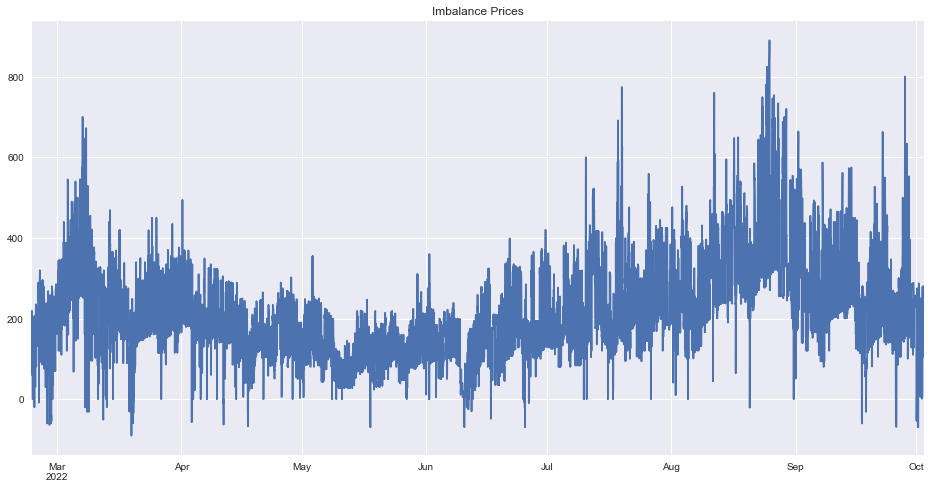

In [167]:
df_wap_bal.imb.plot(figsize=(16,8), title = 'Imbalance Prices')

It is evident that this time series is non stationary since it tends to present trends from time to time.

We will create panel data from the previous time series, and show that the time series itself presents high correlation with the nearby half hour settlement periods.

In [176]:
panel_data = create_panel_df(df_wap_bal.imb)
panel_data.dropna(inplace=True)

# columns: Settlement periods
# index: daily timestamp

panel_data.head(48)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
2022-02-22,188.500,189.00,188.500,120.12,188.50,188.50,153.050,107.66,138.270,145.65,...,130.000,204.140,210.00,108.00,199.000,75.000,75.000,0.000,0.000,0.000
2022-02-23,191.000,198.00,198.000,198.00,214.00,214.00,215.000,214.00,214.000,198.00,...,230.000,230.000,220.00,81.00,199.000,199.000,199.000,197.500,192.000,191.000
2022-02-24,269.000,255.00,100.000,255.00,269.00,255.00,255.000,255.00,255.000,285.00,...,95.000,295.000,295.00,290.00,290.000,290.000,269.000,149.928,270.000,269.000
2022-02-25,140.921,141.20,171.600,200.00,220.00,216.00,179.560,161.77,30.000,30.00,...,279.000,76.000,250.00,140.50,233.000,140.700,226.820,129.000,76.000,141.000
2022-02-26,105.050,234.00,234.000,143.38,138.88,10.07,-63.720,-63.72,-17.060,222.00,...,268.000,268.000,268.00,60.00,143.000,143.600,143.600,153.830,220.000,101.880
2022-02-27,35.000,134.61,118.930,106.53,129.71,118.79,136.260,124.32,126.010,124.07,...,60.000,80.000,270.00,267.00,255.000,0.000,121.000,140.000,121.000,123.090
2022-02-28,163.100,245.00,229.000,245.00,245.00,245.00,229.000,229.00,245.000,245.00,...,285.000,270.000,270.00,258.35,253.240,251.238,245.000,245.000,249.000,257.000
2022-03-01,170.000,177.00,175.000,177.00,165.00,110.00,110.000,165.00,280.000,278.00,...,345.000,189.989,335.00,185.00,296.000,185.000,185.000,185.050,185.050,185.000
2022-03-02,330.000,330.00,299.000,299.00,202.00,204.00,205.000,299.00,299.000,204.00,...,286.920,269.890,277.18,281.18,345.000,236.880,182.500,216.250,299.000,299.000
2022-03-03,220.000,220.00,220.000,215.10,220.00,325.00,248.570,238.56,325.000,384.00,...,235.050,160.000,233.20,404.00,375.000,349.000,349.000,349.000,340.000,325.000


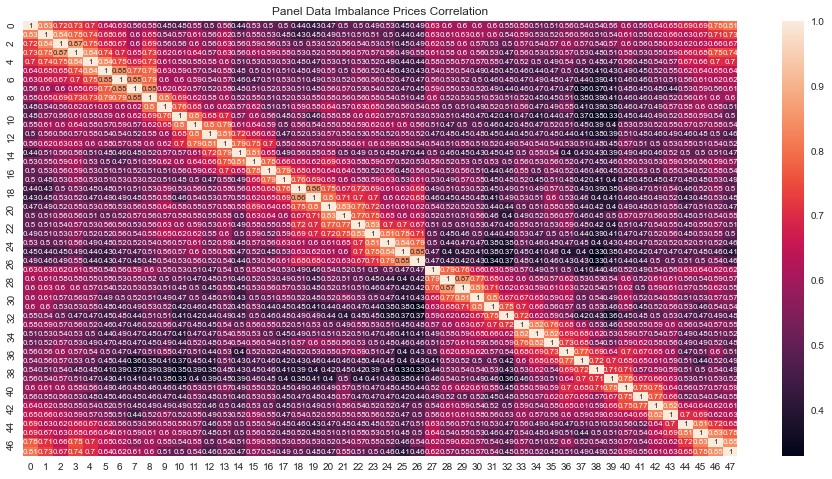

In [181]:
plt.figure(figsize = (16,8))
plt.title('Panel Data Imbalance Prices Correlation')
sns.heatmap(panel_data.corr(), annot = True, annot_kws={"fontsize":8})
plt.show()

The above plot shows that nearby periods show strong correlation, therefore they have *similar* imbalance prices.

# The VWAP 

In this last section we shall look at the Volume Weighted Average Price. The latter is computed from trades, creating specific time buckets for which a weighted average is performed. From an algorithmic trading point of view these prices are not operational since they are not necessarily in the book. Nevertheless, when looking at strategy development they can be good to have an idea if there is some value in a strategy.

<AxesSubplot:title={'center':'VWAP Intraday Power Prices'}>

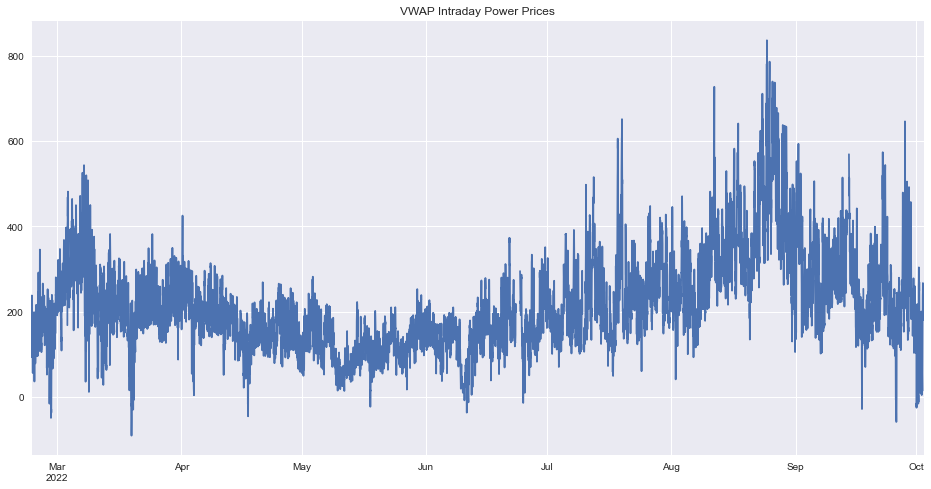

In [182]:
df_wap_bal.wap1.plot(figsize=(16,8), title = 'VWAP Intraday Power Prices')

## Are there some stochastic models for these prices?

This is a very difficult question and still there is still not a final of satisfactory answer in the litterature. 